### Imports

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
from sklearn.metrics import f1_score

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
from xgboost import XGBClassifier

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
from pprint import pprint

### Data preprocess functions

In [14]:
# function to convert strings and object types to number
from sklearn import preprocessing

def labelEncode(data, columns):
    objectData = data[columns]
    objectData = objectData.select_dtypes(exclude=['int64','float64']) # remove columns which are already a number 
    objectDataColumns = list(objectData)
    le = preprocessing.LabelEncoder()
    for column in objectDataColumns:
        objectData[column] = le.fit_transform(objectData[column])
    data.loc[objectData.index,objectData.columns] = objectData # merge to dataframe
    return data

In [15]:
# function to convert string to date time type for easy manipulation
def toDateTime(data, columns):
    for column in columns:
        data[column] = pd.to_datetime(data[column],format='%Y-%m-%d %H:%M:%S')
    return data

In [16]:
# merge similar date columns to fill missing values
def dateCorrMerge(data):
    data.loc[data['reported_date'].isnull(),'reported_date'] = data['discovered_date']
    data.loc[data['start_for_fire_date'].isnull(),'start_for_fire_date'] = data['reported_date']
    data.loc[data['bh_fs_date'].isnull(),'bh_fs_date'] = data['start_for_fire_date']
    data.loc[data['uc_fs_date'].isnull(),'ex_fs_date'] = data['bh_fs_date']
    data.loc[data['ex_fs_date'].isnull(),'ex_fs_date'] = data['uc_fs_date']
    return data

In [17]:
def date2month(date):
    return date.month

def date2sec(date):
    return date.total_seconds()

# calc fire duration and month : substract extingush date from start date
def fireDurMonth(data):
    data['ex_fs_date'] = pd.to_datetime(data['ex_fs_date'],format='%Y-%m-%d %H:%M:%S')
    data['start_for_fire_date'] = pd.to_datetime(data['start_for_fire_date'],format='%Y-%m-%d %H:%M:%S')
    data['fire_duration'] = data['ex_fs_date'] - data['start_for_fire_date']
    data['fire_month'] = data['start_for_fire_date']
    data['fire_duration'] = data['fire_duration'].apply(date2sec)
    data['fire_month'] = data['fire_month'].apply(date2month)
    return data

In [18]:
# oneHot Encode : split text column into numerical columns
import category_encoders as ce

def oneHotEncode(data, columns):
    objectData = data[columns]
    objectData = objectData.select_dtypes(exclude=['int64','float64']) # remove columns which are already a number
    ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
    objectData = ohe.fit_transform(objectData)
    data = pd.merge(data, objectData, right_index=True, left_index=True)
    data = data.drop(columns,axis=1)
    return data

In [19]:
# predict missing weather data to fill null spaces
def fillUsingModel(data,val):
    nulldata_X = data.loc[data[val[0]].isnull(),val[1]]
    data_X = data.loc[data[val[0]].notnull(),val[1]]
    data_Y = data.loc[data[val[0]].notnull(),[val[0]]]
    nulldata_X = labelEncode(nulldata_X, val[1])
    data_X = data_X.fillna('Unknown')
    data_X = labelEncode(data_X, val[1])
    tempModel = RandomForestClassifier(random_state=25)
    tempModel.fit(data_X, data_Y)
    data.loc[data[val[0]].isnull(),val[0]] = tempModel.predict(nulldata_X)
    return data

# Ex: fillUsingModel(data, {0:'fire_type',1:['general_cause_desc','fire_origin','activity_class']})

In [20]:
# Standardization
from sklearn.preprocessing import StandardScaler

def standardizeData(data,columns):
    # Get column names first
    if not columns:
        columns = data.columns
    # Create the Scaler object
    scaler = StandardScaler()
    # Fit your data on the scaler object
    scaled_data = scaler.fit_transform(data[columns])
    data[columns] = pd.DataFrame(scaled_data, columns=columns)
    return data

# Ex: data = fillUsingModel(data,[]) - entire columns considered or specify needed columns 

In [21]:
# Principal component : Dimension reduction (input columns should be standardised)
from sklearn.decomposition import PCA

def pca(data,columnsIn,columnsOut,keepInput):
    dimIn = len(columnsIn)
    dimOut = len(columnsOut)
    if not dimIn:
        dimIn = len(data.columns)
    pca = PCA(n_components=dimOut)
    principalComponents = pca.fit_transform(data[columnsIn])
    pcaData = pd.DataFrame(data=principalComponents, columns = columnsOut)
    data = pd.concat([data, pcaData], axis=1)
    if not keepInput:
        data = data.drop(columnsIn,axis=1)
    return data

# Ex: pca(data,['fire_location_latitude','fire_location_longitude'],['combined'],0)

In [22]:
# data preprocess main function
def preprocess(data) :
    data_processed = data
    # first letter from fire_number : forest area in which the ignition area is located
    data_processed['fire_number'] = data['fire_number'].astype(str).str[0]
    # remove unwanted columns
    data_processed = data_processed.drop(['fire_year','initial_action_by','fire_position_on_slope','assessment_datetime','fire_fighting_start_date','true_cause','det_agent_type','det_agent'],axis = 1)
    # make date format correct
    # data_processed = toDateTime(data_processed,['fire_start_date','discovered_date','reported_date','start_for_fire_date','bh_fs_date','uc_fs_date','ex_fs_date'])
    # correct the missing dates from other columns
    data_processed = dateCorrMerge(data_processed)
    # process the dates to calc month & duration of fire
    data_processed = fireDurMonth(data_processed)
    # remove unwanted columns
    data_processed = data_processed.drop(['fire_start_date','discovered_date','reported_date','bh_fs_date','uc_fs_date','ex_fs_date'],axis = 1)
    # fill unknown values using model
    data_processed = fillUsingModel(data_processed, {0:'fire_type',1:['general_cause_desc','fire_origin','activity_class']})
    data_processed = fillUsingModel(data_processed, {0:'weather_conditions_over_fire',1:['fire_location_latitude','fire_location_longitude','fire_month']})
    data_processed = fillUsingModel(data_processed, {0:'fire_origin',1:['fire_location_latitude','fire_type','general_cause_desc']})
    data_processed = fillUsingModel(data_processed, {0:'fuel_type',1:['fire_location_latitude','fire_origin','fire_type','general_cause_desc']})
    # remove unwanted columns
    data_processed = data_processed.drop(['start_for_fire_date'],axis = 1) # ,'general_cause_desc','activity_class'
    # make data to numeric/seperate column
    # data_processed = oneHotEncode(data_processed,['fire_number','fire_origin','fire_type','weather_conditions_over_fire','fuel_type'])
    # data_processed = labelEncode(data_processed,['fire_number','fire_origin','fire_type','weather_conditions_over_fire','fuel_type'])
    data_processed = labelEncode(data_processed,['general_cause_desc','fuel_type','fire_origin','fire_number','activity_class','fire_type','weather_conditions_over_fire'])
    # standardize data
    data_processed = standardizeData(data_processed,[])
    # dimension reduction
    data_processed = pca(data_processed,['fire_type','fire_origin'],['fire_t_o'],0)
    return data_processed

### Data read

In [23]:
train_data = pd.read_csv('train.csv')

In [24]:
test_data_X = pd.read_csv('test.csv')

In [25]:
train_data_Y = train_data['size_class'] # column to be predicted 

In [26]:
train_data_X = train_data.drop(columns = "size_class")

### Preprocess

In [27]:
train_data_X_processed = preprocess(train_data_X)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to floa

In [28]:
train_data_X_processed.head()

,fire_number,fire_location_latitude,fire_location_longitude,general_cause_desc,activity_class,weather_conditions_over_fire,fuel_type,fire_duration,fire_month,fire_t_o
0,-1.385152,-1.339038,0.076026,0.863416,-0.017750,-0.302512,1.048201,-0.196263,0.416132,1.108799
1,-0.344748,0.918272,-0.604122,-0.826339,-0.881431,0.828789,-1.286151,-0.188972,-0.166827,-0.140906
2,-0.344748,1.289240,0.305581,-0.826339,-0.881431,-2.565113,-1.286151,-0.093824,-0.166827,-2.214929
3,-1.385152,-1.337764,0.075504,0.863416,-0.017750,0.828789,1.048201,-0.195855,-0.749787,1.108799
4,1.389259,0.345061,0.730122,1.145041,0.845932,-0.302512,-1.286151,-0.141602,-1.332746,-2.214929


In [29]:
# save the processed data to csv (to save time)
# train_data_X_processed.to_csv('trainProcessed.csv',index=False)
# read already processed data
# train_data_X_processed = pd.read_csv('trainProcessed.csv')

In [30]:
train_data_X_processed.dtypes

fire_number                     float64
fire_location_latitude          float64
fire_location_longitude         float64
general_cause_desc              float64
activity_class                  float64
weather_conditions_over_fire    float64
fuel_type                       float64
fire_duration                   float64
fire_month                      float64
fire_t_o                        float64
dtype: object

In [31]:
# data split

In [32]:
train_data_X, validate_data_X, train_data_Y, validate_data_Y = train_test_split(train_data_X_processed, train_data_Y, train_size=0.75, random_state=25)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Model training and tuning

In [33]:
# model = DecisionTreeClassifier(random_state=25)
model = RandomForestClassifier(n_estimators=100, random_state=25)
# model = XGBClassifier(random_state=25, n_estimators=150, max_depth=5)

Hyperparameter Tuning

In [20]:
# Parameters currently in use :
pprint(model.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 25,
 'verbose': 0,
 'warm_start': False}


In [23]:
# Parameter grid for XGBoost
# params_grid = {
#         'base_score': [0.1, 0.2, 0.3],
#         'min_child_weight': [0.9, 1],
#         'gamma': [1, 1.2],
#         'subsample': [0.5, 0.6],
#         'colsample_bytree': [0.5, 0.6],
#         'n_estimators': [120, 150, 170],
#         'max_depth': [5]
#         }

# Parameter grid for random forest
params_grid = {
        'bootstrap': [True],
        'max_depth': [28, 30, 32],
        'max_features': ['auto'],
        'min_samples_leaf': [1],
        'min_samples_split': [8, 10],
        'n_estimators': [1520, 1600, 1680]
        }

Random search

In [22]:
# Random search of parameters
random_search = RandomizedSearchCV(estimator=model, param_distributions=params_grid, n_iter=200, cv=3, verbose=2, random_state=25, n_jobs=-1)
# Fit the random search model
random_search.fit(train_data_X, train_data_Y)
# Best param after fitting
pprint(random_search.best_params_)
# Evaluate Random Search
model = random_search.best_estimator_
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 566.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 590.4min finished


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1600}
('Macro-F1 Score :', 0.5658184785767804, '(+/- 0.05)')


Grid search

In [24]:
# Grid search of parameters for model
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, cv=5, verbose=2, n_jobs=-1)
# Fit the grid search to the data
grid_search.fit(train_data_X, train_data_Y)
# Best param after fitting
pprint(grid_search.best_params_)
# Evaluate best grid search model
model = grid_search.best_estimator_
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.7min finished


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1680}
('Macro-F1 Score :', 0.567039865737865, '(+/- 0.05)')


In [33]:
# model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=30, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=10,
#             min_weight_fraction_leaf=0.0, n_estimators=1680, n_jobs=None,
#             oob_score=False, random_state=25, verbose=0, warm_start=False)

In [34]:
model.fit(train_data_X, train_data_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

predict validation data

In [35]:
pred_validate_data_Y = model.predict(validate_data_X)

### Evaluation

In [36]:
print('Validation accuracy score:', accuracy_score(validate_data_Y, pred_validate_data_Y))

('Validation accuracy score:', 0.7500629881582263)


In [37]:
print('Macro F1-score:', f1_score(validate_data_Y, pred_validate_data_Y, average='macro'))

('Macro F1-score:', 0.5100786965784527)


Cross Validation

In [38]:
# 5-Fold Cross validation
cv_scores = cross_val_score(model, train_data_X, train_data_Y, cv=5, scoring='f1_macro')
print("Macro-F1 Score :", np.mean(cv_scores), "(+/- %0.2f)" % (cv_scores.std() * 2))

('Macro-F1 Score :', 0.5269811969309941, '(+/- 0.05)')


In [39]:
# re-train model on all train data

In [40]:
train_data_X = train_data_X_processed
train_data_Y = train_data['size_class'] # column to be predicted 

In [41]:
model.fit(train_data_X, train_data_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

Feature importance

In [42]:
importance = pd.DataFrame()
importance['Feature'] = train_data_X.columns
importance['Importance'] = model.feature_importances_
importance.set_index('Feature', inplace=True)

importance.sort_values(by='Importance', ascending=False)

,Importance
Feature,
fire_duration,0.311379
fire_location_latitude,0.182602
fire_location_longitude,0.146943
fire_month,0.065316
fire_t_o,0.055305
activity_class,0.055055
fuel_type,0.053473
fire_number,0.045688
general_cause_desc,0.042347


Confusion Matrix

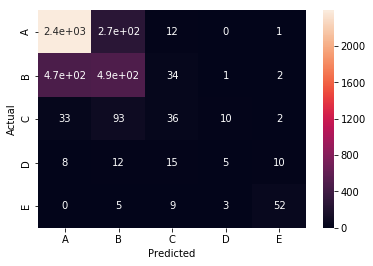

In [43]:
# Using seaborn: (plot_confusion_matrix has some version issues)
import seaborn as sn
confusion_matrix = pd.crosstab(validate_data_Y, pred_validate_data_Y, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()

### Predict on Test dataset

In [44]:
pred_test_data_Y = pd.DataFrame()
pred_test_data_Y['fire_number'] = test_data_X['fire_number']

In [45]:
test_data_X = preprocess(test_data_X)

C:\Users\uib50578\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


In [46]:
# save the processed data to csv (to save time)
# test_data_X.to_csv('testProcessed.csv',index=False)
# read already processed data
# test_data_X = pd.read_csv('testProcessed.csv')

In [47]:
test_data_X.dtypes

fire_number                     float64
fire_location_latitude          float64
fire_location_longitude         float64
general_cause_desc              float64
activity_class                  float64
weather_conditions_over_fire    float64
fuel_type                       float64
fire_duration                   float64
fire_month                      float64
fire_t_o                        float64
dtype: object

In [48]:
pred_test_data_Y['size_class'] = model.predict(test_data_X)

In [49]:
pred_test_data_Y.shape

(3969, 2)